# Google stocks dataset

## 1. Предобработка

Приведем временной ряд цен акций Google на момент закрытия торгов к стационарному виду.

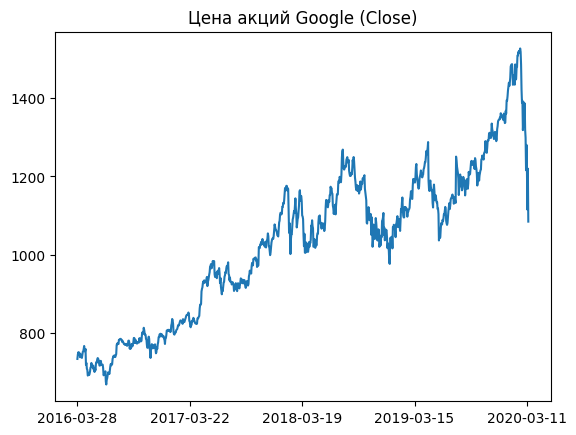

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/raw/Google_Historical_StockPrice2.csv")[:1000:]

plt.xticks(df.index[::249], df.Date[::249])
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.Close.plot()
plt.title("Цена акций Google (Close)")
plt.show()

### Временное преобразование

Объединим значения ряда по месяцам и построим новый временной ряд. В качестве стоимости будем рассматривать максимальную стоимость акций в этот месяц.

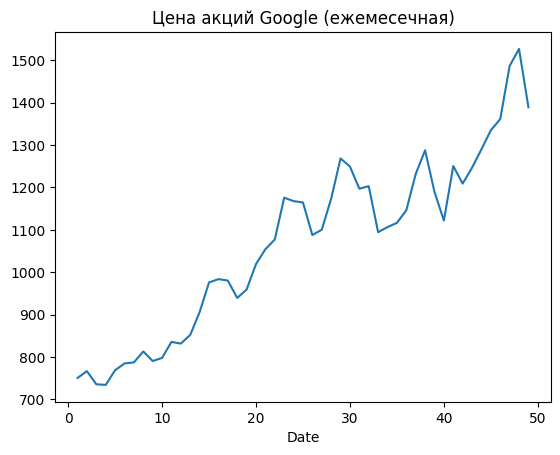

In [2]:
from datetime import datetime

months = df.Date.map(lambda a: a.date().month)
ids = (months != months.shift()).cumsum()
df = df.groupby(ids).max()

df.Date = pd.DatetimeIndex(df.Date).to_period("M")
df.Close.plot()
plt.title("Цена акций Google (ежемесечная)")
plt.show()

Рассмотрим декомпозицию полученного временного ряда:

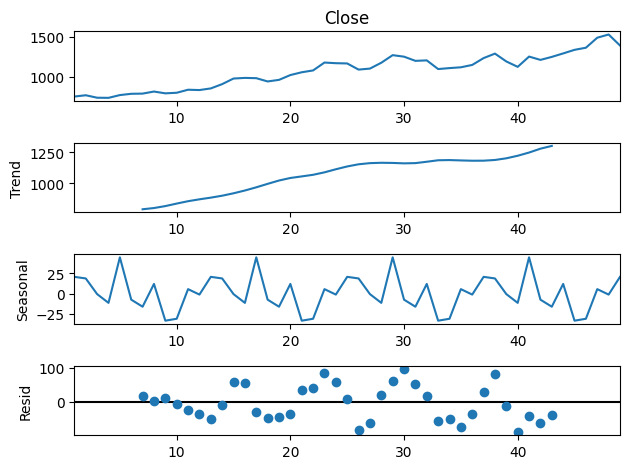

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df.Close, period=12).plot()
plt.show()

Хорошо выделяется тренд, однако с выявлением сезонности могут возникнуть проблемы, поскольку дисперсия графика `Residual` (остаток) увеличивается.

### Стабилизация дисперсии

Применим преобразование Бокса-Кокса для стабилизации дисперсии.

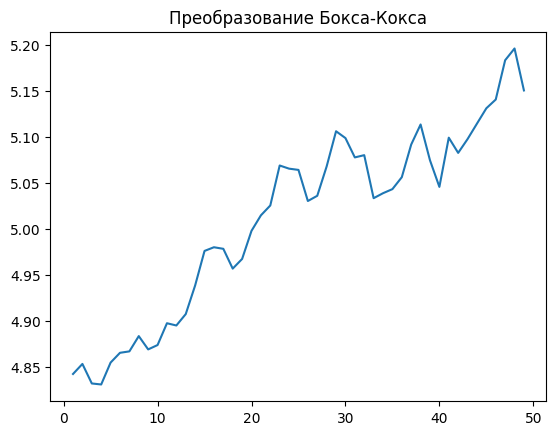

In [4]:
from scipy.special import boxcox

df["Corrected"] = boxcox(df.Close, -0.1)
plt.plot(df.Corrected)
plt.title("Преобразование Бокса-Кокса")
plt.show()

### Удаление тренда

Найдем "линию наилучшего соответствия" с помощью линейной регрессии и вычтем полученные значения, чтобы "наклонить график".

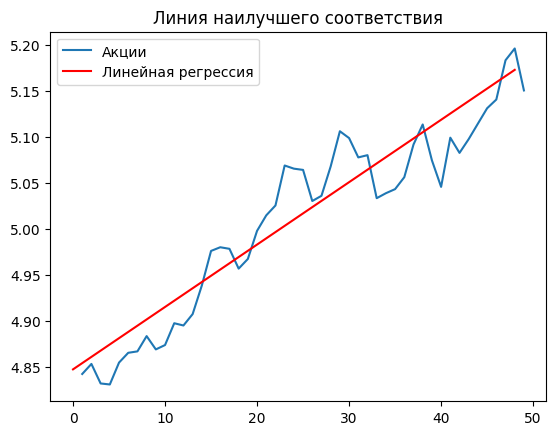

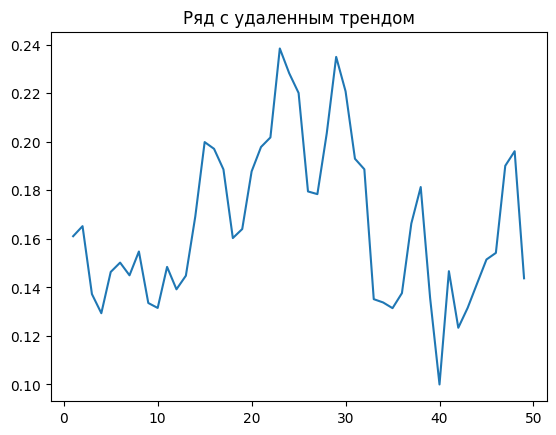

In [5]:
from scipy.stats import linregress

(s, i, _, _, _) = linregress(df.index, df.Corrected)
plt.plot(df.Corrected, label="Акции")
plt.plot(df.index.map(lambda x: i + s * x), color="r", label="Линейная регрессия")
plt.title("Линия наилучшего соответствия")
plt.legend(loc="upper left")
plt.show()

def inverse(dataframe, start=0, end=-1):
    return dataframe - height + (np.arange(start, len(dataframe) if end == -1 else end) * s + i)

df.Corrected = df.Corrected - (df.index * s + i)
height = abs(min(df.Corrected)) + 0.1
df.Corrected = df.Corrected + height
plt.plot(df.Corrected)
plt.title("Ряд с удаленным трендом")
plt.show()

### Поиск сезонности

Для поиска сезонности применим автокорелляцию.

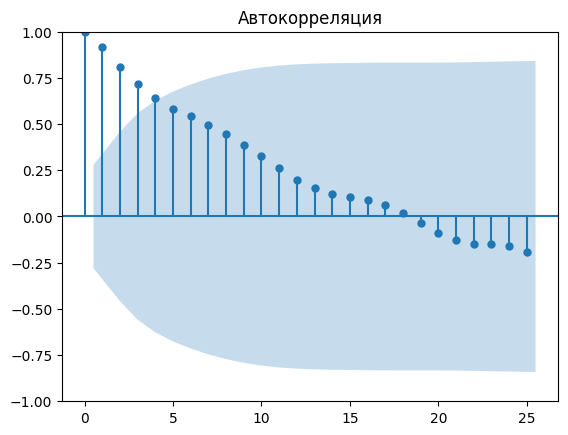

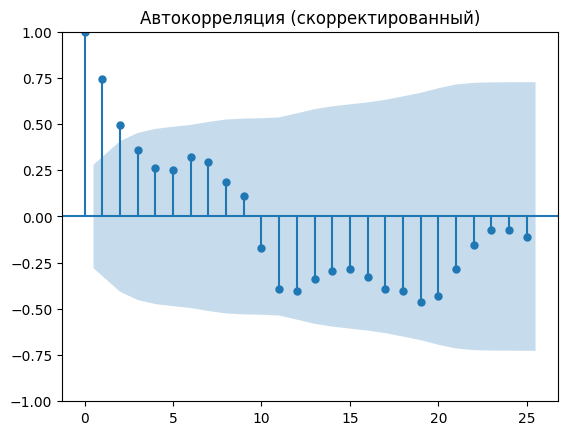

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df.Close, lags=25)
plt.title("Автокорреляция")
plot_acf(df.Corrected, lags=25)
plt.title("Автокорреляция (скорректированный)")
plt.show()

Рассматривая авторегрессию и представленное выше разложение временного ряда, можно предположить, что у данного временного ряда встречается 4 пика, а значит $60:4=15$ - длина одного сезона. Однако, более логично в качестве длины одного сезона брать 12 месяцев (1 год), это не может сильно ухудшить результаты, но может их улучшить.

### Проверка на стационарность

Проверим скорректированный временной ряд на стационарность тестом Дики-Фуллера (ADF) с уровнем значимости $\alpha = 5\%$.

гипотезы:
* $H_0 - $временной ряд обладает единичным корнем (нестационарен)
* $H_1 - $временной ряд не обладает единичным корнем (стационарен)

In [7]:
import statsmodels.api as sm

test = sm.tsa.adfuller(df.Corrected)
if test[0] < test[4]["5%"]:
    print("H0 - отвергается, обработанный ряд стационарен\n")
else:
    print("H0 - принимается, обработанный ряд нестационарен\n")
print("Вероятность H0 (p-value) 'Corrected': ", round(test[1], 5))
print("Вероятность H0 (p-value) 'Close'    : ", round(sm.tsa.adfuller(df.Close)[1], 5))

H0 - отвергается, обработанный ряд стационарен

Вероятность H0 (p-value) 'Corrected':  0.00182
Вероятность H0 (p-value) 'Close'    :  0.92694


## 2. Обучение моделей

### Модель Хольта-Уинтерса

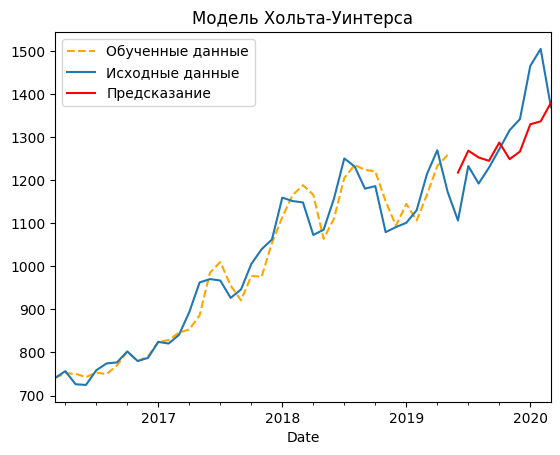

In [153]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.special import inv_boxcox

df.index = df.Date
fit = ExponentialSmoothing(
    df.Corrected[:39],
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()

inv_boxcox(inverse(fit.fittedvalues), -0.1).plot(color="orange", style="--", label="Обученные данные")
inv_boxcox(inverse(df.Corrected), -0.1).plot(label="Исходные данные")
inv_boxcox(inverse(fit.forecast(10), 40, 50), -0.1).plot(color="r", label="Предсказание")
plt.title("Модель Хольта-Уинтерса")
plt.legend(loc="upper left")
plt.show()

### ARIMA

Autoregressive Integrated Moving-Average

* $AR(p) : p$  коэффициент авторегрессии (предыдущие $p$ значений)
* $MA(q) : q$  коэффициент скользящего среднего (предыдущие $q$ значений)
* $I(d) : d$ коэффицент дифференцирования ($d$ раз продифференциированный ряд)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-180.750, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-181.096, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-178.991, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-179.062, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-183.058, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-180.827, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-178.810, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-179.780, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-180.166, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-178.414, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.847 seconds


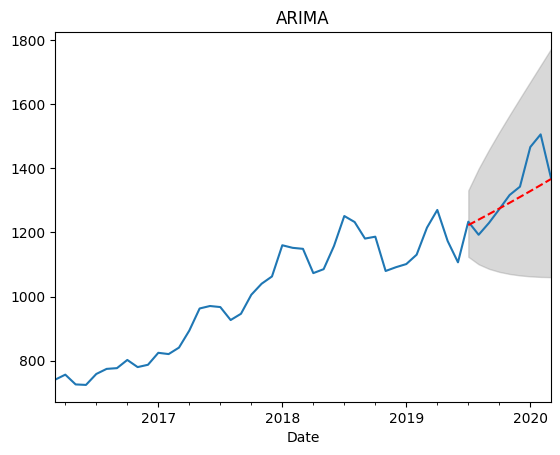

In [164]:
from pmdarima.arima import auto_arima

model = auto_arima(
    df.Corrected[:39],
    start_p=0,
    start_q=0,
    test="adf",
    max_d=4,
    max_q=4,
    m=12,
    start_P=0,
    seasonal=True,
    error_action ="ignore",
    supress_warnings=True,
    trace=True)

fitted, confint = model.predict(n_periods=12, return_conf_int=True)
prediction_series = pd.Series(fitted, index=df.index[40:])
cf = pd.DataFrame(confint)

inv_boxcox(inverse(df.Corrected), -0.1).plot()
inv_boxcox(inverse(prediction_series, 41, 50), -0.1).plot(color="r", style="--")
plt.fill_between(prediction_series.index,
                 inv_boxcox(inverse(cf[0][:9], 41, 50), -0.1),
                 inv_boxcox(inverse(cf[1][:9], 41, 50), -0.1),
                 color="grey", alpha=0.3)
plt.title("ARIMA")
plt.show()

## 3. Метрика

In [170]:
from sklearn.metrics import mean_absolute_percentage_error

error_arima = mean_absolute_percentage_error(df.Corrected[40:], prediction_series)
error_hw = mean_absolute_percentage_error(df.Corrected[40:], fit.forecast(9))

print("MAPE:")
print("* ARIMA:        ", error_arima)
print("* Holt-Winters: ", error_hw)

MAPE:
* ARIMA:         0.12484784190813178
* Holt-Winters:  0.16590658252299184
